In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def ext(path):
    txt = open(path, 'r')
    lines = txt.readlines()
    df = pd.DataFrame()
    for line in tqdm(lines):
        df = pd.concat([df, pd.DataFrame(np.array(line.replace(',', '').replace('\n', '').split(' ')).reshape(1, -1))])
    df = df.reset_index(drop=True)
    df.columns = ['Date', 'Timestamp', 'Leg-1', 'Leg-2', 'Conv']
    return df

In [62]:
def split(string):
    return string.replace(',', '').replace('\n', '').split(' ')
import os
dfs = []
for name in tqdm(os.listdir('/content')):
    if name.split('.')[-1] == 'txt':
        txt = open(os.path.join('/content', name), 'r')
        lines = txt.readlines()[94:-1]
        df = pd.DataFrame(list(map(split, lines)))
        df.columns = ['Date', 'Timestamp', 'Leg-1', 'Leg-2', 'Conv']
        dfs.append(df)

100%|██████████| 23/23 [00:01<00:00, 12.28it/s]


In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import numpy as np

In [5]:
def ConvResamp(df, timeframe):
    dfNew = df.copy()
    df.loc[:,'DateTime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Timestamp.astype(str), errors='coerce')
    df.set_index('DateTime', append=False, inplace=True)

    conv = {                                                                                                             
              'Timestamp':'last',                                                                                                    
              'Leg-1':'last',                                                                                                       
              'Leg-2':'last',                                                                                                        
              'Conv': 'last'
          }

    dfNew = df.resample(timeframe).agg(conv)
    dfNew.dropna(inplace = True)
    dfNew.columns = ['Timestamp', 'Leg-1', 'Leg-2', 'Conv']
    dfNew[['Leg-1', 'Leg-2', 'Conv']] = dfNew[['Leg-1', 'Leg-2', 'Conv']].astype(float)
    return dfNew

In [6]:
import plotly.graph_objects as go
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]
    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

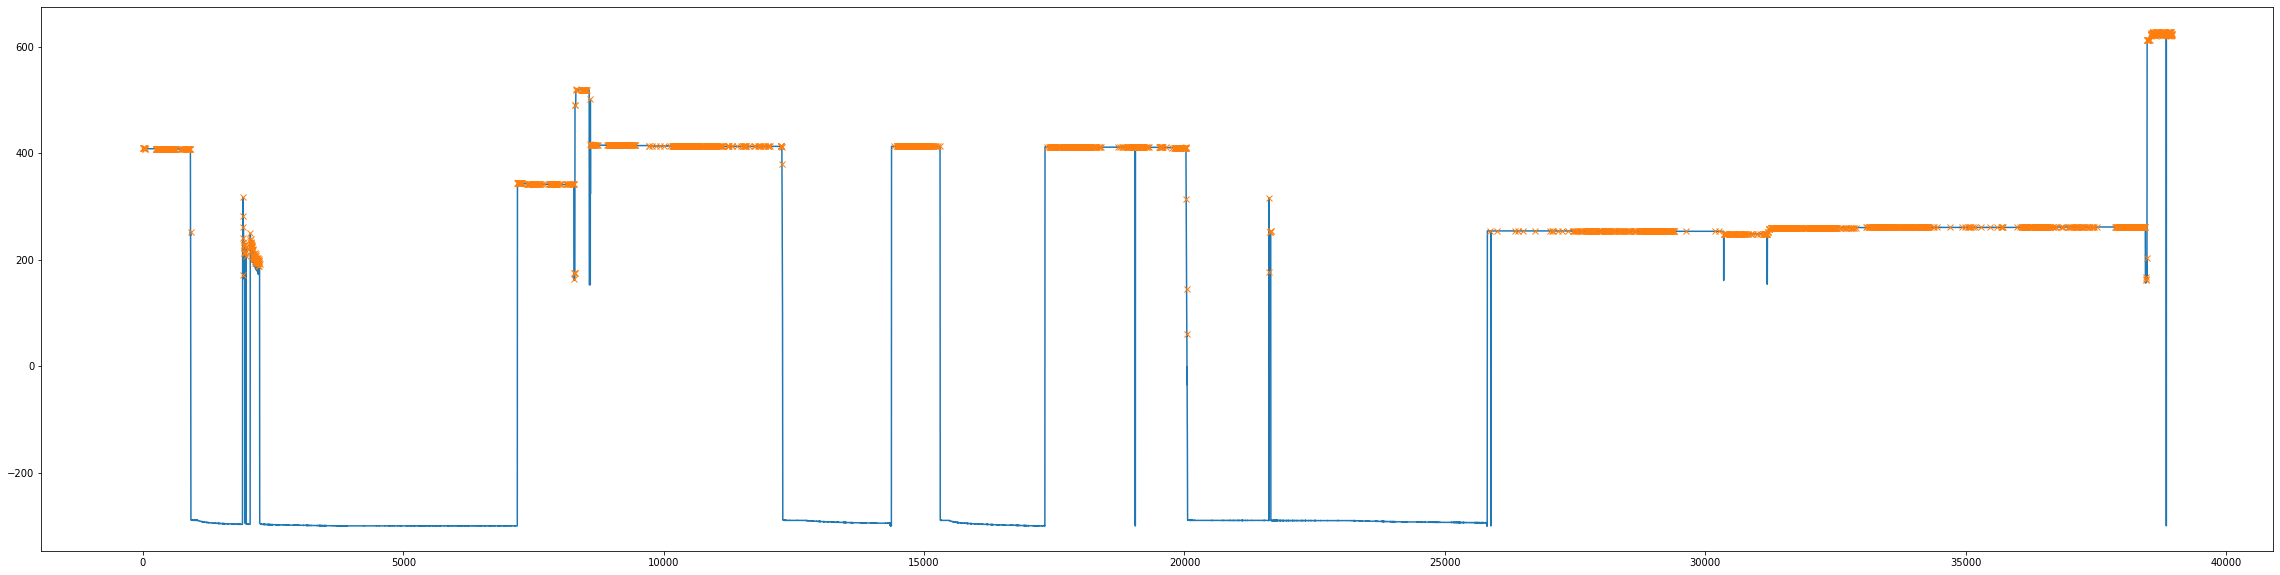

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ConvResamp(df, '1min')['Timestamp'].values,
    y=smoothTriangle(ConvResamp(df, '1min')['Conv'].values, 5),  # setting degree to 10
    mode='markers',
    marker=dict(
        size=5,
        color='#C190F0',
        symbol='triangle-up'
    )))

fig.show()
plt.figure(figsize=(40, 10))
peaks, pts = find_peaks(ConvResamp(df, '1min')['Conv'], distance=1, height=5)
plt.plot(ConvResamp(df, '1min')['Conv'].values)
plt.plot(peaks, np.array(ConvResamp(df, '1min')['Conv'])[peaks], "x")

plt.show()

In [38]:
from sklearn.neighbors import NearestNeighbors

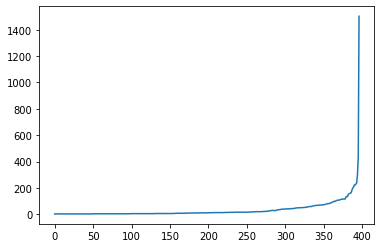

In [ ]:
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=100)
neighbors_fit = neighbors.fit(peaks.reshape(-1, 1))
distances, indices = neighbors_fit.kneighbors(peaks.reshape(-1, 1))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [32]:
!pip install dbscan1d

     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 143kB 12.9MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 727kB 13.8MB/s 
     |████████████████████████████████| 747kB 22.8MB/s 
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20


['yellow', 'blue', 'lightgreen', 'red', 'orange', 'purple', 'cyan', 'snow', 'deeppink']


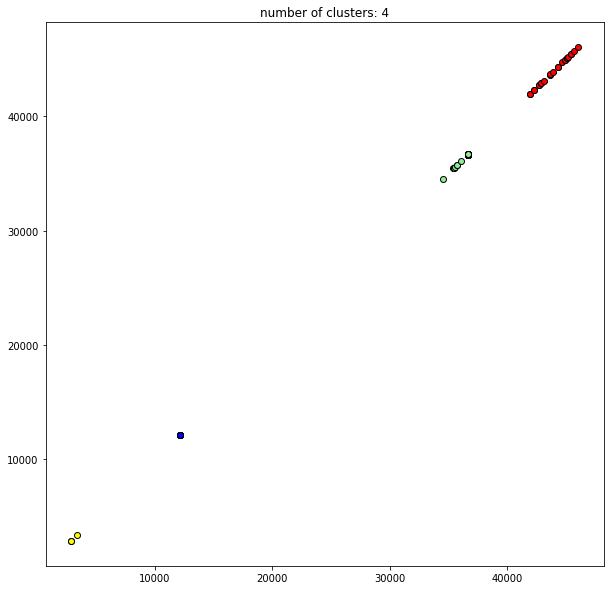

In [105]:
from dbscan1d.core import DBSCAN1D
db = DBSCAN1D(eps=1000, min_samples=3)
plt.figure(figsize=(10, 10))
# get labels for each point
labels = db.fit_predict(peaks)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = ['yellow', 'blue', 'lightgreen', 'red', 'orange', 'purple', 'cyan', 'snow', 'deeppink']
print(colors)
for k, col in zip(unique_labels, colors):
	if k == -1:
		# Black used for noise.
		col = 'k'

	class_member_mask = (labels == k)
	xy = peaks.reshape(-1, 1)[class_member_mask & core_samples_mask]
	plt.plot(xy[:, 0], xy[:, 0], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
	
  #xy = peaks.reshape(-1, 1)[class_member_mask & ~core_samples_mask]
	#plt.plot(xy[:, 0], xy[:, 0], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

plt.title('number of clusters: %d' %n_clusters_)
plt.show()

In [106]:

newdf = pd.DataFrame(
    {
        'Values': ConvResamp(df, '1min')['Leg-2'].iloc[peaks].values,
        'Cluster': db.labels_,
        'Datetime': ConvResamp(df, '1min')['Leg-2'].iloc[peaks].index,
        'Peaks': peaks
    }
)
newdf.set_index('Datetime', append=False, inplace=True)
newdf = newdf[newdf.Cluster>-1]
for i in set(newdf['Cluster'].values):
    print(newdf[newdf['Cluster']==i].iloc[-1].name - newdf[newdf['Cluster']==i].iloc[0].name)

0 days 08:11:00
0 days 00:15:00
1 days 11:44:00
2 days 20:21:00


In [60]:
newdf['Cluster'].value_counts()

4    7
1    6
3    5
0    5
2    3
Name: Cluster, dtype: int64

In [37]:
newdf = pd.DataFrame(
    {
        'Values': ConvResamp(df, '1min')['Conv'].iloc[peaks].values,
        'Cluster': labels,
        'Datetime': ConvResamp(df, '1min')['Conv'].iloc[peaks].index,
        'Peaks': peaks
    }
)
newdf.set_index('Datetime', append=False, inplace=True)

In [59]:
for i in set(newdf['Cluster'].values):    
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(newdf[newdf['Cluster'] == i]['Peaks'].values.reshape(-1, 1))
    distances, indices = neighbors_fit.kneighbors(newdf[newdf['Cluster'] == i]['Peaks'].values.reshape(-1, 1))
    print('Cluster:', i, ' Closeness:', sum(sum(distances)) / len(newdf[newdf['Cluster'] == i]['Peaks']))

Cluster: 0  Closeness: 20.4
Cluster: 1  Closeness: 99.0
Cluster: 2  Closeness: 7.0
Cluster: 3  Closeness: 72.2
Cluster: 4  Closeness: 5.714285714285714


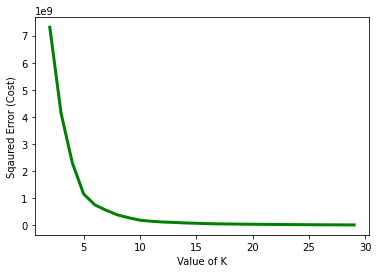

In [ ]:
cost =[]
for i in range(2, 30):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(peaks.reshape(-1, 1))
    cost.append(KM.inertia_)	

plt.plot(range(2, 30), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show()

In [40]:
for i in set(newdf['Cluster'].values):    
    neighbors = NearestNeighbors(n_neighbors=1)
    neighbors_fit = neighbors.fit(newdf[newdf['Cluster'] == i]['Peaks'].values.reshape(-1, 1))
    distances, indices = neighbors_fit.kneighbors(newdf[newdf['Cluster'] == i]['Peaks'].values.reshape(-1, 1))
    print('Cluster:', i, ' Closeness:', sum(sum(distances)) / len(newdf[newdf['Cluster'] == i]['Peaks']))

Cluster: 0  Closeness: 0.0
Cluster: 1  Closeness: 0.0
Cluster: 2  Closeness: 0.0
Cluster: 3  Closeness: 0.0
Cluster: 4  Closeness: 0.0
Cluster: 5  Closeness: 0.0
Cluster: 6  Closeness: 0.0
Cluster: 7  Closeness: 0.0
Cluster: 8  Closeness: 0.0
Cluster: 9  Closeness: 0.0


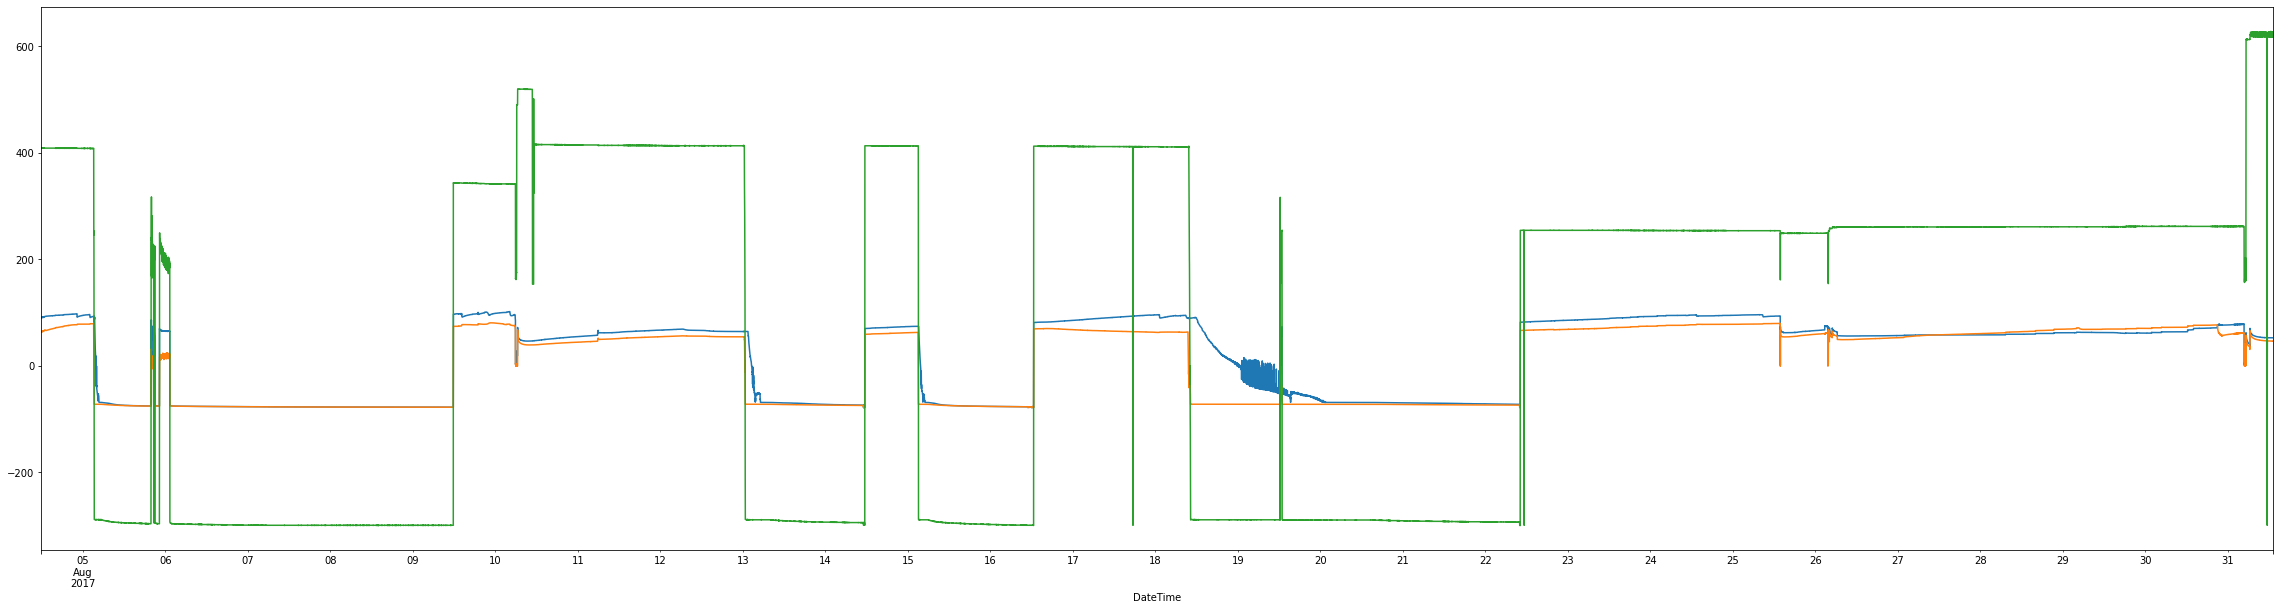

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 10))
ConvResamp(df, '1min')['Leg-2'].plot()
ConvResamp(df, '1min')['Leg-1'].plot()
ConvResamp(df, '1min')['Conv'].plot()
plt.show()

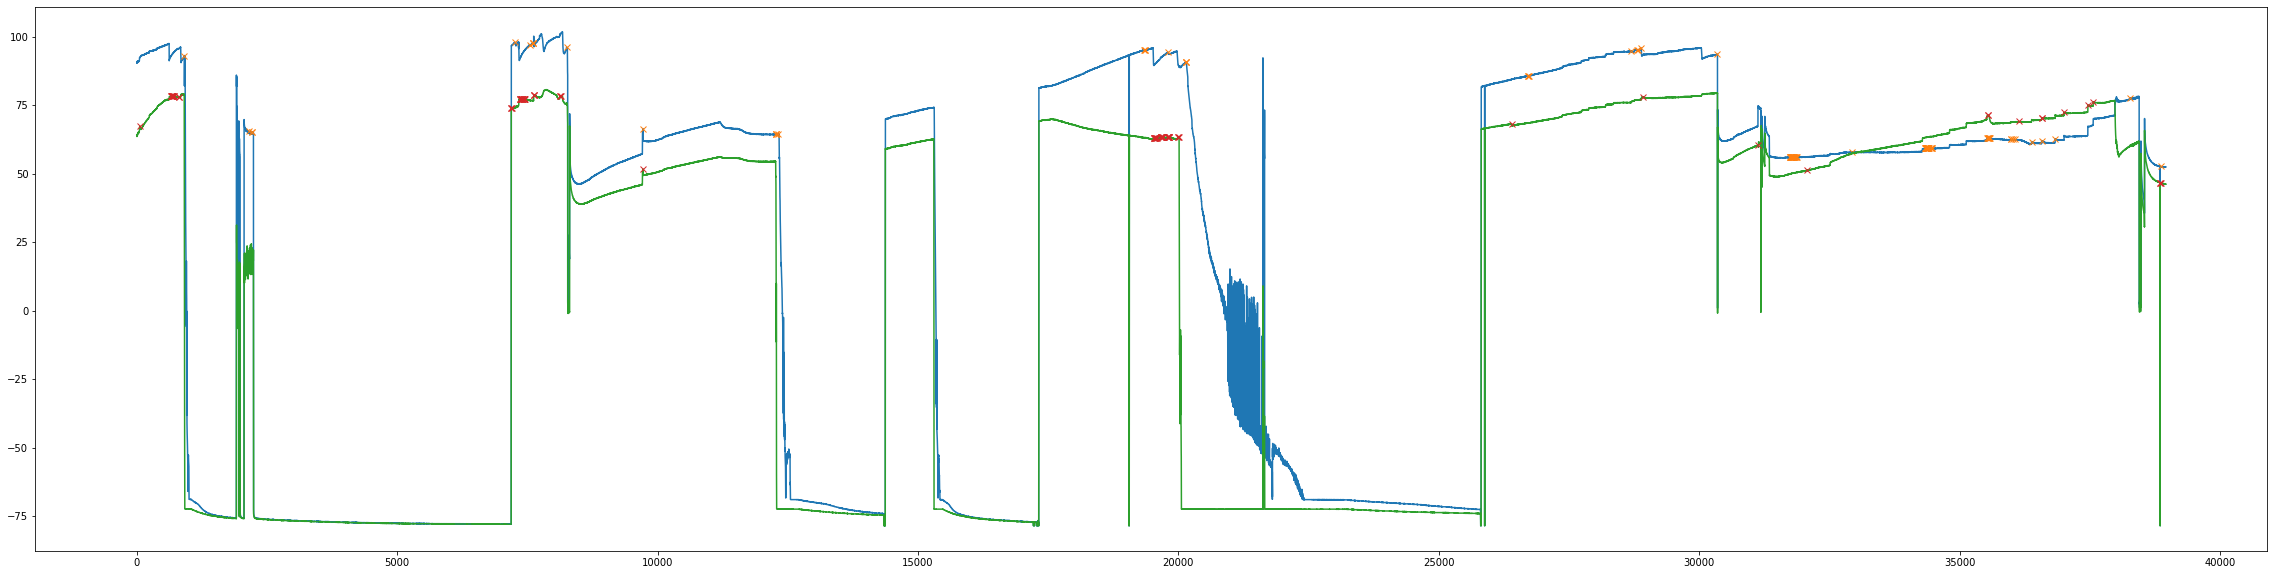

In [14]:
plt.figure(figsize=(40, 10))
peaks, pts = find_peaks(ConvResamp(df, '1min')['Leg-2'], distance=1, height=df['Leg-2'].astype('float').mean(), width=7, prominence=(0.2, 5))
plt.plot(ConvResamp(df, '1min')['Leg-2'].values)
plt.plot(peaks, np.array(ConvResamp(df, '1min')['Leg-2'])[peaks], "x")
peaks, pts = find_peaks(ConvResamp(df, '1min')['Leg-1'], distance=1, height=df['Leg-1'].astype('float').mean(), width=7, prominence=(0.2, 5))
plt.plot(ConvResamp(df, '1min')['Leg-1'].values)
plt.plot(peaks, np.array(ConvResamp(df, '1min')['Leg-1'])[peaks], "x")
plt.show()

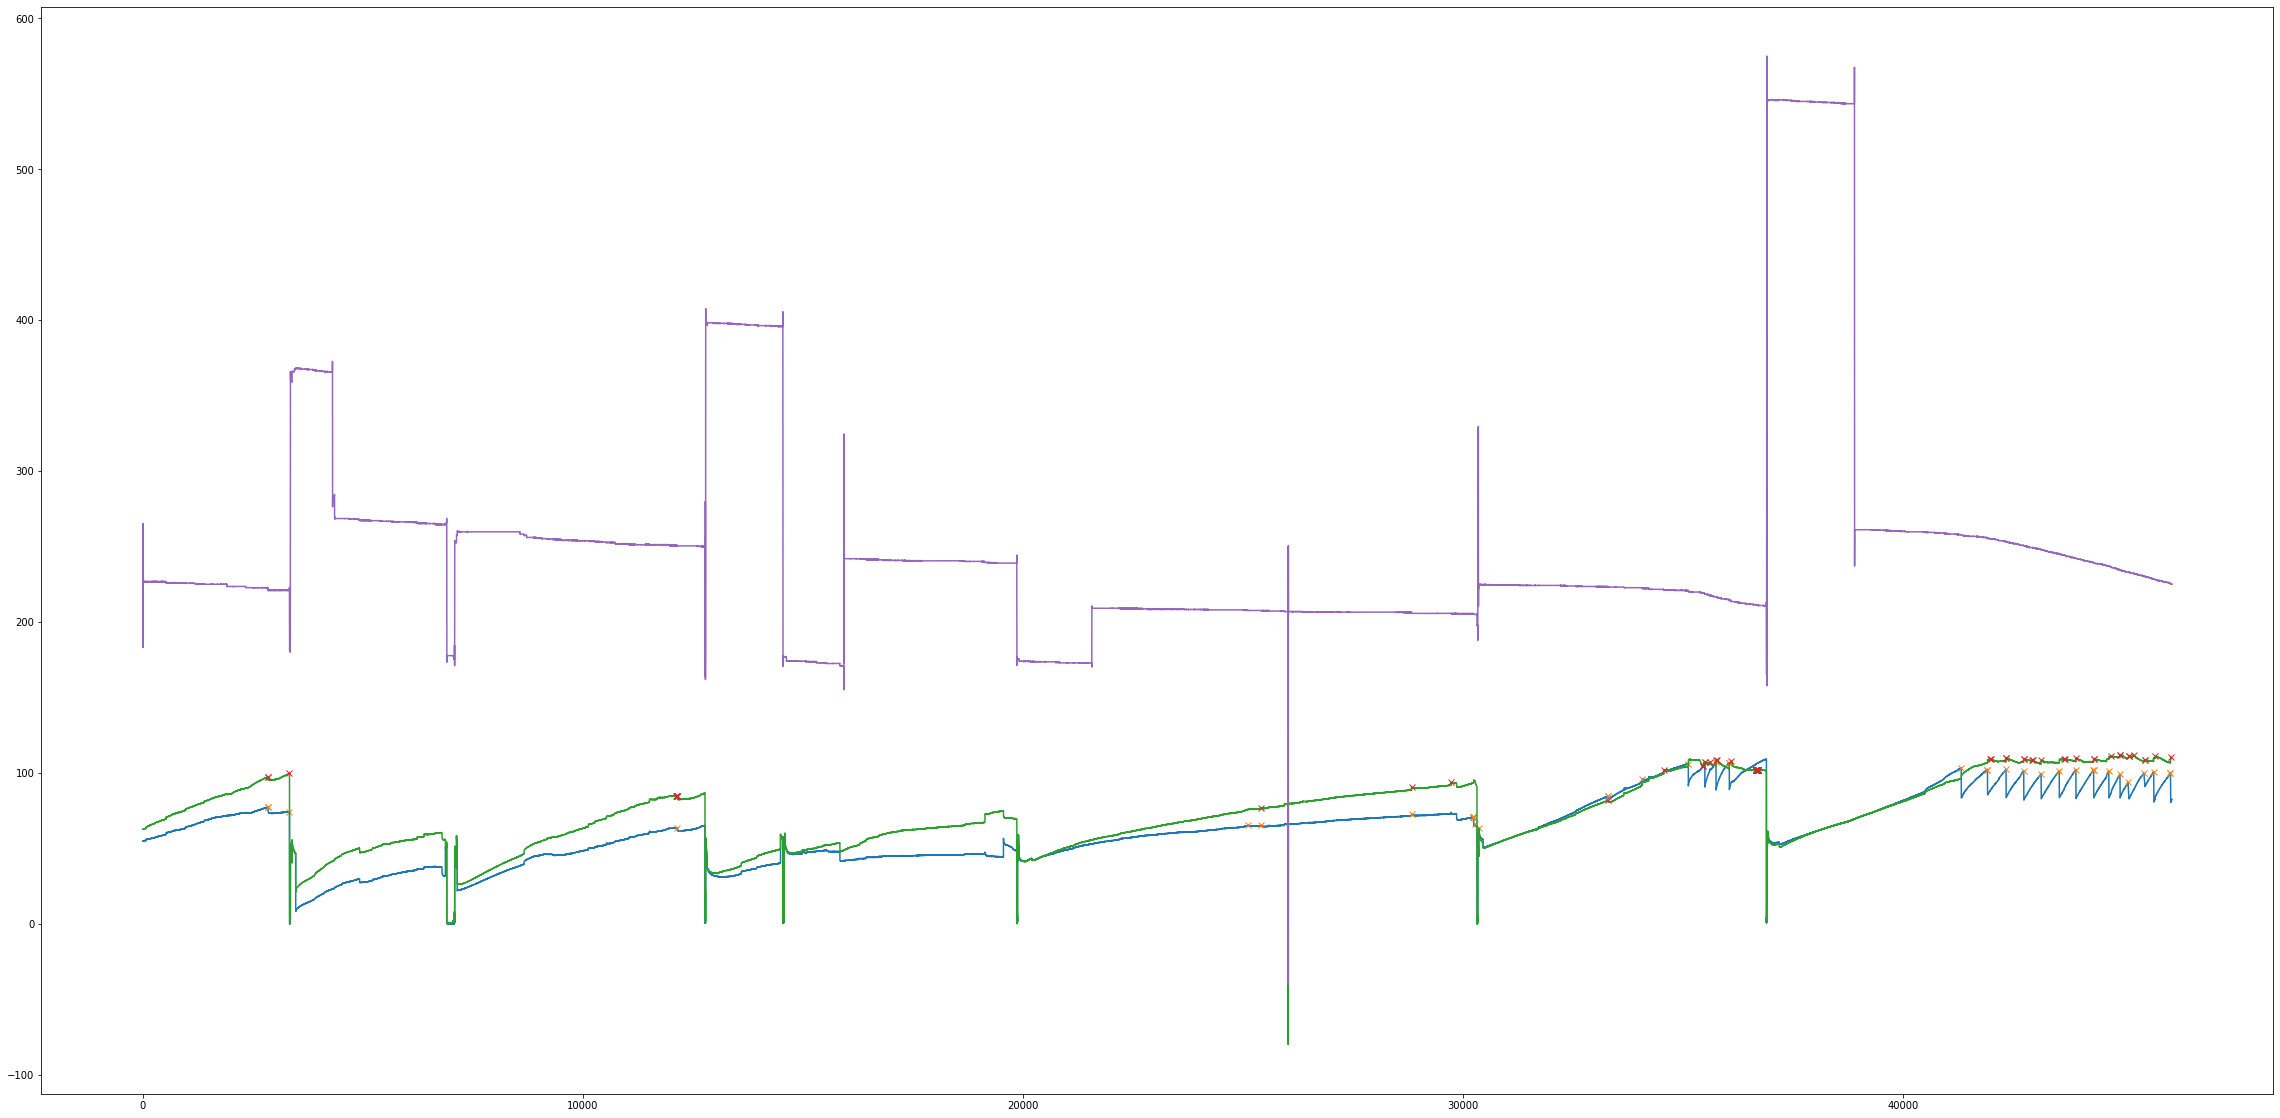

In [100]:
df =dfs[11]
plt.figure(figsize=(40, 20))
peaks1, pts1 = find_peaks(ConvResamp(df, '1min')['Leg-1'], distance=1, height=df['Leg-1'].astype('float').mean(), width=1, prominence=(0.5, 25))
plt.plot(ConvResamp(df, '1min')['Leg-1'].values)
plt.plot(peaks1, np.array(ConvResamp(df, '1min')['Leg-1'])[peaks1], "x")
peaks, pts = find_peaks(ConvResamp(df, '1min')['Leg-2'], distance=1, height=df['Leg-2'].astype('float').mean(), width=1, prominence=(0.5, 50))
plt.plot(ConvResamp(df, '1min')['Leg-2'].values)
plt.plot(peaks, np.array(ConvResamp(df, '1min')['Leg-2'])[peaks], "x")
from scipy.signal import savgol_filter
peaks2, pts2 = find_peaks(ConvResamp(df, '1min')['Conv'], distance=1, height=df['Conv'].astype('float').mean(), width=7)
plt.plot(savgol_filter(ConvResamp(df, '1min')['Conv'].values, 5, 3))
#plt.plot(peaks2, np.array(ConvResamp(df, '1min')['Conv'])[peaks2], "x")

plt.show()

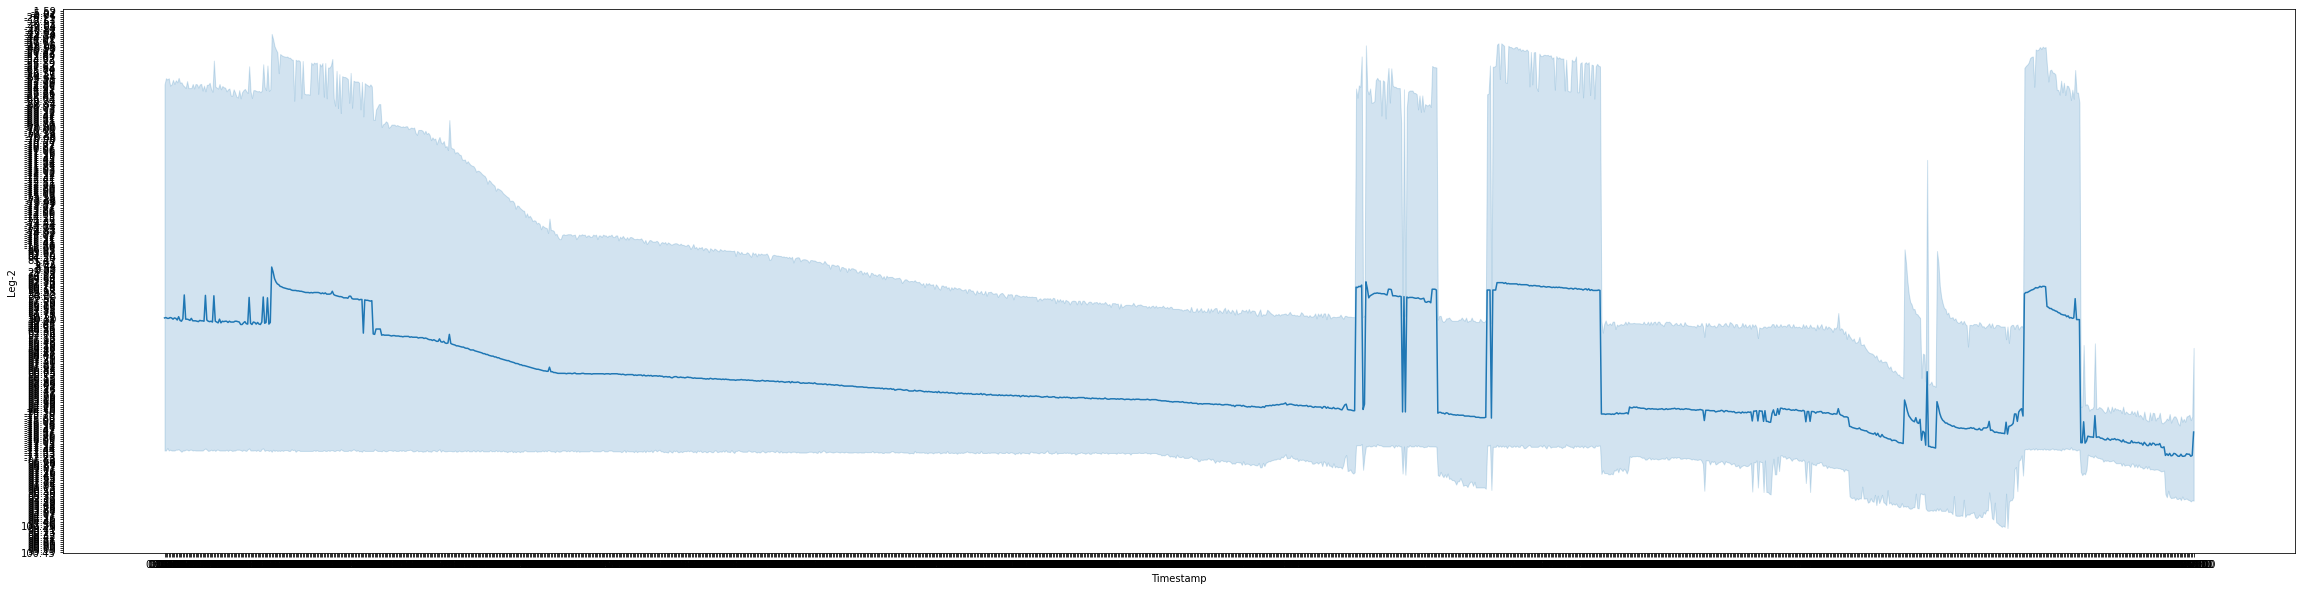

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 10))
sns.lineplot(x='Timestamp', y='Leg-2', data=df.loc[lambda d: d.Date.isin(['2017/08/05', '2017/08/06', '2017/08/07', '2017/08/08', '2017/08/09']), :])
plt.show()

In [ ]:
df.loc[lambda d: d.Date.isin(['2017/08/05', '2017/08/06', '2017/08/07', '2017/08/08', '2017/08/09']), :]

,Date,Timestamp,Leg-1,Leg-2,Conv
DateTime,,,,,
2017-08-05 00:00:10,2017/08/05,0:00:10,78.22,94.75,408.4
2017-08-05 00:01:10,2017/08/05,0:01:10,78.22,94.65,408.4
2017-08-05 00:02:10,2017/08/05,0:02:10,78.22,94.65,408.4
2017-08-05 00:03:10,2017/08/05,0:03:10,78.22,94.75,408.4
2017-08-05 00:04:10,2017/08/05,0:04:10,78.22,94.65,408.4
...,...,...,...,...,...
2017-08-09 23:55:10,2017/08/09,23:55:10,80.16,98.42,341.9
2017-08-09 23:56:10,2017/08/09,23:56:10,80.16,98.42,341.6
2017-08-09 23:57:10,2017/08/09,23:57:10,80.16,98.52,341.9
